In [1]:
import copy
import glob
import importlib
import itertools
import math
import operator
import os
import random
import time
from os.path import *
import psutil
import shutil

import keras.layers as layers
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import cnn_builder as cbuild
import cnn_runner as crun
import config
import dr_methods as drm
import seg_methods as sm
import voi_methods as vm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import niftiutils.deep_learning.cnn_components as cnnc

%matplotlib inline
np.set_printoptions(3, suppress=True)
#np.random.seed(0)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


## DDPG

In [4]:
import ddpg.env as denv
import ddpg.main as qmain
import ddpg.learning_nets as ln
import ddpg.task_nets as tn
importlib.reload(cbuild)
C = config.Config()

In [2]:
def memory():
    pid = os.getpid()
    py = psutil.Process(pid)
    gigs = py.memory_info()[0]/2.**30
    print('Memory use:', gigs)
    return gigs

In [ ]:
dqn_generator = cbuild._train_gen_ddpg()

In [4]:
Q = qmain.CRSNet(.75)

In [ ]:
replay_conf = {'size': 10000,
                'learn_start': 100,
                'partition_num': 100,
                'total_step': 10000,
                'batch_size': 4} #4
BATCH_SIZE = replay_conf["batch_size"]

Q.load_models(replay_conf)

In [6]:
Q.env.train_model.load_weights(join(C.model_dir, "train.h5"))
Q.env.pred_model.load_weights(join(C.model_dir, "pred.h5"))

In [7]:
action = [.5]*3+[1]*3+[.5,.9,.1,0]

In [8]:
img, true_seg, true_cls = next(dqn_generator)

In [ ]:
center = action[:3] * np.array(img.shape[:3])
dx = action[3:6] * np.array(img.shape[:3]) / 2
#phase_shift = action[6:9] * 10

bbox = [[round(center[i]-dx[i]),
    round(center[i]+dx[i])] for i in range(3)]

#wide_bbox = np.zeros((3,2))
for i in range(3):
    bbox[i][1] = max(self.min_x+1, min(self.img.shape[i] - 1, bbox[i][1]))
    bbox[i][0] = max(1, min(bbox[i][1] - self.min_x, bbox[i][0]))

In [ ]:
sl = [slice(bbox[i], bbox[i+1]) for i in [0,2,4]]

In [ ]:
cropI = tr.rescale_img(img[sl], C.dims)
crop_pred_seg, crop_pred_cls = self.pred_model.predict(np.expand_dims(cropI, 0))

In [ ]:
Q.env.pred_model.predict(np.expand_dims(cropI, 0))

In [ ]:
importlib.reload(qmain)
Q = qmain.CRSNet(.75)
Q.train(dqn_generator, verbose=True)

In [5]:
Q.save_models()

In [4]:
os.listdir(C.model_dir)

['actor.h5', 'actor_T.h5', 'critic.h5', 'critic_T.h5', 'pred.h5', 'train.h5']

In [6]:
for fn in glob.glob(join(C.model_dir,"*"))[:4]:
    os.remove(fn)

In [5]:
os.remove(join(C.model_dir, "replay_buffer.bin"))
os.remove(join(C.model_dir, "unet_buffer.bin"))

In [5]:
shutil.rmtree(C.model_dir)

In [6]:
os.makedirs(C.model_dir)

In [24]:
cropI = np.random.normal(size=(1,*C.dims,3))

crop_true_seg = np.random.normal(size=(1,*C.dims,3))
true_cls = np.random.uniform(size=(1,3))

y_true = np.random.normal(size=(1,*C.dims,3))
y_pred = np.random.normal(size=(1,*C.dims,4))

loss_layer = train_model.layers[-1]

In [ ]:
importlib.reload(tn)
for _ in range(10):
    log_vars = [K.get_value(x)[0] for x in train_model.layers[-1].log_vars]
    loss = np.sum(np.exp(-log_vars[0]) * K.get_value(tn.hetero_cls_loss(y_true, y_pred)) + log_vars[0], -1)
    print(np.mean(loss))
    memory();

In [30]:
A = prediction_model.predict(cropI)

In [ ]:
for _ in range(10):
    train_model.train_on_batch([cropI, crop_true_seg, true_cls], None)
    A=prediction_model.predict(cropI);
    print(A[1])
    memory();

In [ ]:
importlib.reload(qmain)
Q = qmain.CRSNet(1.)

replay_conf = {'size': 10000,
        'learn_start': 100,
        'partition_num': 100,
        'total_step': 10000,
        'batch_size': 4}
BATCH_SIZE = replay_conf["batch_size"]

Q.load_models(replay_conf)

In [ ]:
Q.critic.model.summary()

In [ ]:
Q.actor.model.summary()

In [ ]:
Q.env.pred_model.summary()

In [8]:
importlib.reload(qmain)
#Q = qmain.CRSNet(.5)
#img, true_seg, true_cls = next(dqn_generator)
liver_seg, tumor_seg, seg_var, cls = Q.run(img)

....................................................................................................100 steps


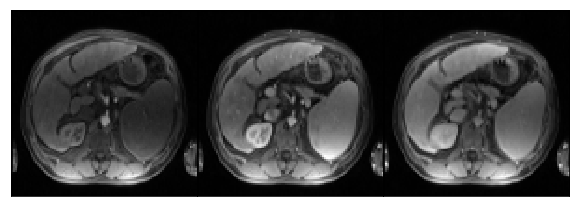

In [9]:
vis.draw_slices(img)

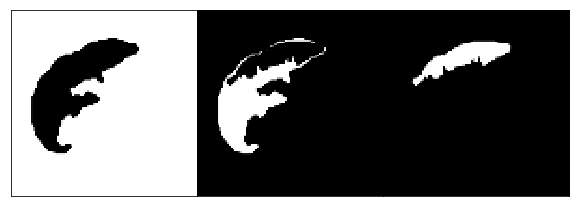

In [10]:
vis.draw_slices(true_seg)

In [18]:
tumor_seg.max()

0.3468440454853562

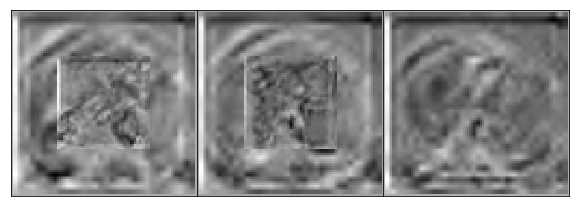

In [16]:
vis.draw_slices(liver_seg, normalize=[0,.05])

In [ ]:
hist = M.fit_generator(gen, steps_per_epoch=2, epochs=2)

prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)
assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1
hist = trainable_model.fit([X, Y1, Y2], nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)

[np.exp(K.get_value(log_var[0]))**0.5 for log_var in trainable_model.layers[-1].log_vars]

## Classifier

In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()
T.get_best_hyperparams()
#T.epochs = 40
#T.steps_per_epoch = 750

In [ ]:
T.padding = ['same', 'same']
T.pool_sizes = [(2,2,2),(2,2,2)]
T.f = [64,64,64,64,64,64,64]
T.skip_con = True
T.epochs = 20

In [ ]:
drm.dcm2npy_batch(acc_nums=["E100113043"])
#vm.reset_accnum('E105464882')

In [ ]:
vm.plot_check(2, "E102088195");

In [ ]:
vm.xref_dirs_with_excel()

In [ ]:
importlib.reload(crun)
crun.run_fixed_hyperparams(T=T)

In [125]:
importlib.reload(densenet)
pred_model, train_model = densenet.get_models()

In [ ]:
importlib.reload(densenet)
model = densenet.DenseNet(depth=19, dropout_rate=.1)
model.summary(line_length=120)

In [ ]:
model = keras.models.load_model(join(C.model_dir, "models_305.h5"))

In [5]:
model = keras.models.load_model(join(C.model_dir, "classifier_1.h5"))

In [ ]:
importlib.reload(cbuild)
T.get_best_hyperparams()
T.epochs = 30
T.steps_per_epoch = 300
T.global_pool = False
model = cbuild.build_cnn_hyperparams(T)
model.summary(line_length=120)

In [ ]:
dims_df = pd.read_csv(C.dims_df_path, index_col=0)

In [ ]:
importlib.reload(cbuild)
#Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4)#, use_vois=False)#, Z_test_fixed=Z_reader)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [8]:
print(C.run_stats_path)

E:\LIRADS\excel\overnight_run.csv


In [7]:
model.save(join(C.model_dir, "classifier_1.h5"))

In [ ]:
model.predict(X_train_orig[20:23])

In [ ]:
Y_train_orig[:20]

In [ ]:
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [ ]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

print(accuracy_score(y_true, y_pred))
#y_true_simp, y_pred_simp, _ = cnna.merge_classes(y_true, y_pred)
#print(accuracy_score(y_true_simp, y_pred_simp))